<a href="https://colab.research.google.com/github/Tejaswi-Mahadev/RL_HA/blob/main/SmartHomeAutomation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python code implements a smart home energy management simulation. The system involves smart devices, environmental states, and a decision-making agent using the Upper Confidence Bound (UCB) algorithm for optimizing device usage. It models the interactions between devices and their environment, focusing on energy consumption, comfort levels, and efficiency.

**Key Components**

1. **Data Classes**

            WeatherData: Represents outdoor weather conditions.

Attributes: temperature, humidity, cloud_cover, wind_speed, is_raining.

EnvironmentState: Represents the current environment in the smart home.

Attributes: temperature, humidity, occupancy, time_of_day, day_of_week,
outdoor_weather, room_brightness, air_quality.

DeviceAction: Represents an action taken by a smart device.

Attributes: device_id, mode, power_level.
Includes a __str__ method for string representation.

2. **Weather Simulation**

                        WeatherSimulator
Simulates outdoor weather changes based on the time of day and day of the week.
Generates temperature, humidity, cloud cover, wind speed, and rain probability using random variations and sinusoidal patterns.


3. **Smart Devices**

                      SmartDevice

Represents devices like ACs, heaters, lights, and ventilators.
Modes: Each device has different modes (e.g., "eco", "normal", "power") with associated power levels.

Attributes: Device state, power consumption, runtime, and maintenance needs.
Methods:

_initialize_modes: Defines operating modes for each device type.
calculate_energy_consumption: Calculates energy consumption and comfort based on environmental states.

update_state: Updates runtime and checks for maintenance needs.

4. **Agent for Decision-Making**
                        SmartHomeUCB

Uses Upper Confidence Bound (UCB) for balancing exploration and exploitation when selecting device actions.

Attributes:

devices: List of devices.

all_actions: All possible actions for the devices.

action_counts: Tracks how often each action is taken.

action_values: Stores the reward value for each action.

total_tries: Counts total action selection iterations.

Methods:

_get_all_actions: Generates all possible actions for all devices.

select_actions: Chooses actions based on UCB values, adjusting for context (e.g., time of day, occupancy).

update: Updates action counts and values based on observed rewards.

5. **Environment Simulation**

                   SmartHomeEnvironment

Models the smart home environment and its interactions with devices.

Attributes:

devices: List of smart devices.

weather_simulator: Instance of WeatherSimulator.

current_state: The initial environment state.

hour, day: Track time progression.

history: Records simulation history.

Methods:

_initialize_state: Sets the initial environmental state.

step: Simulates one time step, applying actions to devices and updating the environment.

_update_state: Updates environmental variables based on time, weather, and random variations.

6. **Visualization**

               *plot_comprehensive_results*

Visualizes the results of the simulation, including:

Energy consumption over time.

Comfort score vs. energy consumption.

Daily consumption patterns.

Uses Matplotlib and Seaborn for plotting.


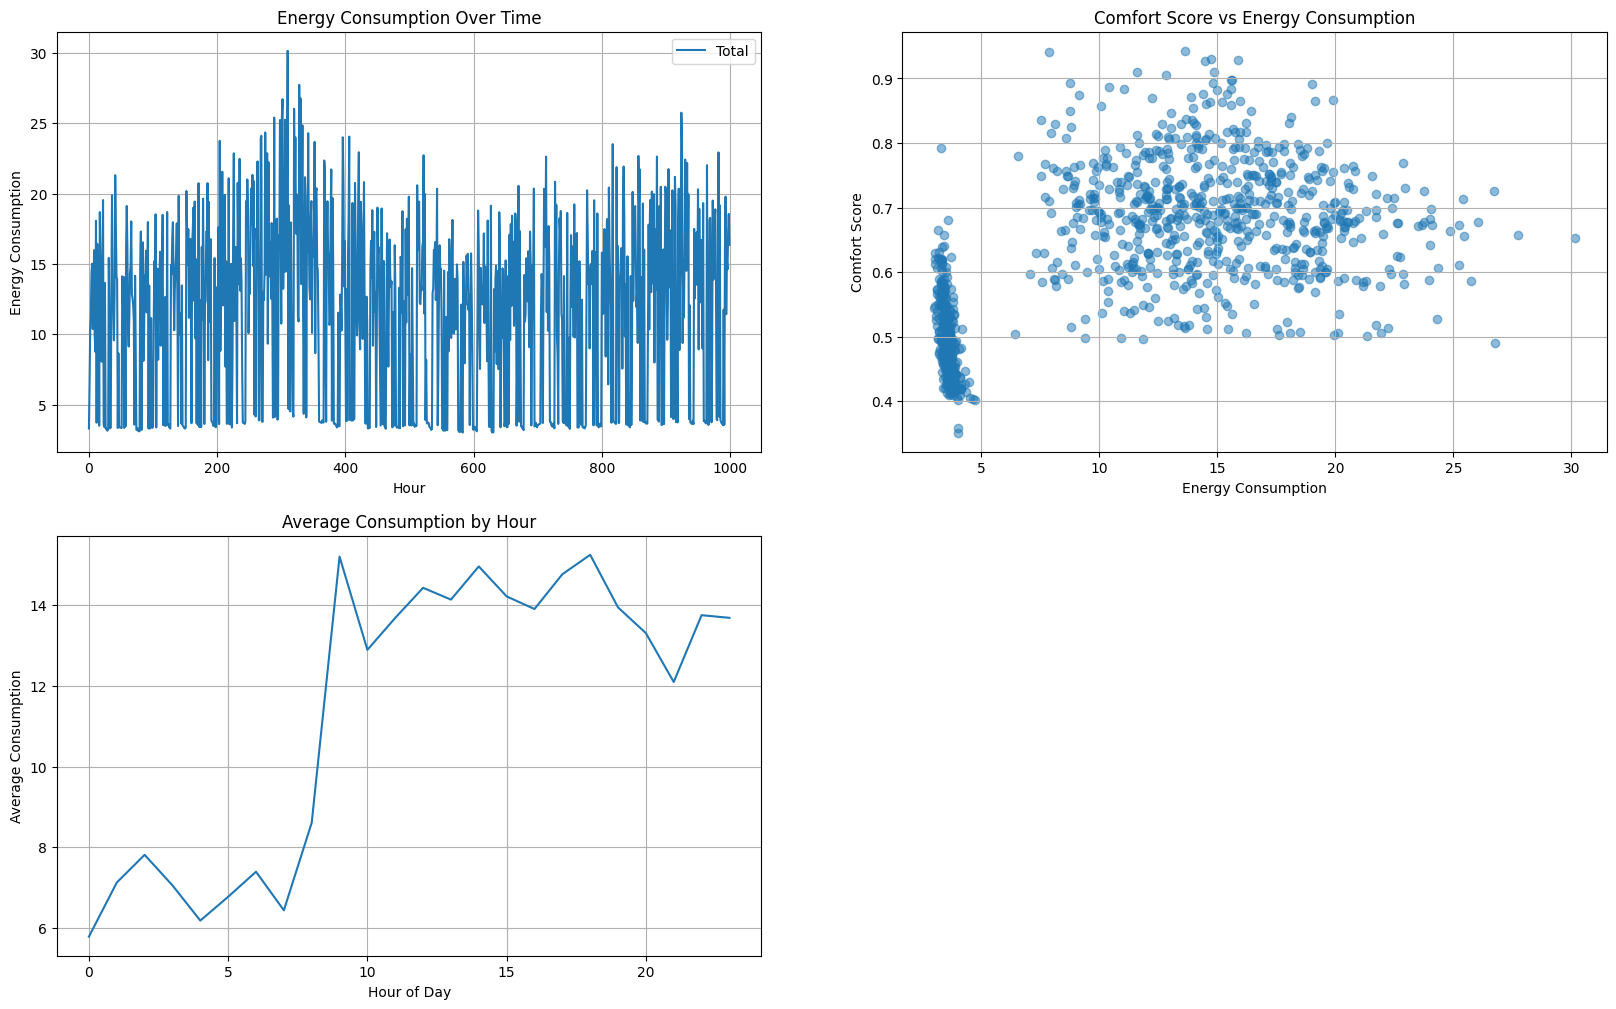

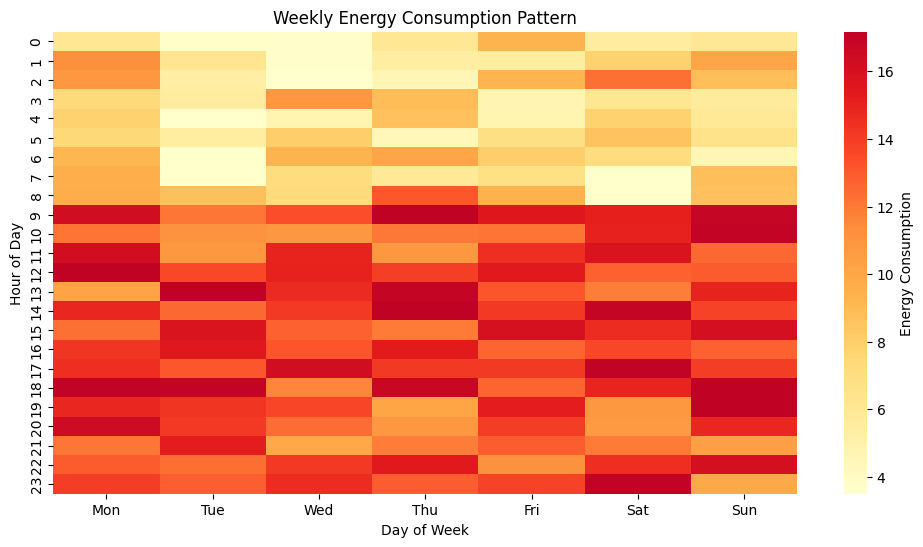

In [6]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

@dataclass
class WeatherData:
    temperature: float
    humidity: float
    cloud_cover: float
    wind_speed: float
    is_raining: bool

@dataclass
class EnvironmentState:
    temperature: float
    humidity: float
    occupancy: bool
    time_of_day: int
    day_of_week: int
    outdoor_weather: WeatherData
    room_brightness: float
    air_quality: float

class WeatherSimulator:
    def __init__(self):
        self.base_temp = 25
        self.base_humidity = 60
        self.hour = 0

    def get_weather(self, time_of_day: int, day_of_week: int) -> WeatherData:
        # Temperature varies with time of day
        temp_variation = -5 * np.cos(2 * np.pi * time_of_day / 24)
        temperature = self.base_temp + temp_variation + np.random.normal(0, 2)

        # Humidity varies inversely with temperature
        humidity = self.base_humidity - 0.3 * temp_variation + np.random.normal(0, 5)
        humidity = np.clip(humidity, 30, 90)

        # Cloud cover and rain probability
        cloud_cover = np.random.beta(2, 5)
        is_raining = np.random.random() < (cloud_cover * 0.5)

        # Wind speed with daily pattern
        wind_speed = 5 + 3 * np.sin(2 * np.pi * time_of_day / 24) + np.random.normal(0, 1)
        wind_speed = max(0, wind_speed)

        return WeatherData(temperature, humidity, cloud_cover, wind_speed, is_raining)

@dataclass
class DeviceAction:
    device_id: str
    mode: str
    power_level: int

    def __str__(self):
        return f"{self.device_id}-{self.mode}-{self.power_level}"

class SmartDevice:
    def __init__(self, device_id: str, device_type: str, base_consumption: float):
        self.device_id = device_id
        self.device_type = device_type
        self.base_consumption = base_consumption
        self.modes = self._initialize_modes()
        self.state = "OFF"
        self.current_power = 0
        self.total_runtime = 0
        self.maintenance_needed = False

    def _initialize_modes(self) -> Dict[str, List[int]]:
        if self.device_type == "AC":
            return {
                "eco": [1, 2, 3],
                "normal": [4, 5, 6],
                "power": [7, 8, 9]
            }
        elif self.device_type == "heater":
            return {
                "eco": [1, 2],
                "normal": [3, 4],
                "power": [5, 6]
            }
        elif self.device_type == "lights":
            return {
                "eco": [1],
                "normal": [2],
                "power": [3]
            }
        elif self.device_type == "ventilation":
            return {
                "eco": [1, 2],
                "normal": [3],
                "power": [4, 5]
            }

    def calculate_energy_consumption(self, action: DeviceAction, env_state: EnvironmentState) -> Tuple[float, float]:
        base = self.base_consumption * action.power_level
        efficiency = 1.0

        # Factor in device wear and tear
        if self.total_runtime > 1000:
            efficiency *= 0.9
        if self.maintenance_needed:
            efficiency *= 0.8

        # Weather impact
        if env_state.outdoor_weather.is_raining:
            efficiency *= 0.95

        # Time of day impact
        if 22 <= env_state.time_of_day <= 6:
            base *= 1.2  # Higher consumption at night

        # Device-specific adjustments
        if self.device_type == "AC":
            temp_diff = abs(env_state.temperature - 22)
            humidity_factor = 1 + (env_state.humidity - 50) / 100
            consumption = base * (1 + 0.1 * temp_diff) * humidity_factor
            comfort_impact = 1 / (1 + temp_diff)

        elif self.device_type == "heater":
            temp_diff = max(18 - env_state.temperature, 0)
            consumption = base * (1 + 0.15 * temp_diff)
            comfort_impact = 1 / (1 + temp_diff)

        elif self.device_type == "lights":
            brightness_need = 1 - env_state.room_brightness
            consumption = base * (1 + 0.5 * brightness_need)
            comfort_impact = action.power_level / 3 if env_state.occupancy else 0

        elif self.device_type == "ventilation":
            air_quality_factor = 1 - env_state.air_quality
            consumption = base * (1 + 0.2 * air_quality_factor)
            comfort_impact = 1 / (1 + air_quality_factor)

        # Apply efficiency factor
        consumption /= efficiency

        return consumption, comfort_impact

    def update_state(self, runtime: int):
        self.total_runtime += runtime
        if self.total_runtime > 1000 and np.random.random() < 0.1:
            self.maintenance_needed = True

class SmartHomeUCB:
    def __init__(self, devices: List[SmartDevice]):
        self.devices = devices
        self.all_actions = self._get_all_actions()
        self.action_counts = {str(action): 0 for action in self.all_actions}
        self.action_values = {str(action): 0.0 for action in self.all_actions}
        self.total_tries = 0
        self.history = []
        self.device_stats = {device.device_id: {'total_consumption': 0, 'avg_comfort': 0}
                           for device in devices}

    def _get_all_actions(self) -> List[DeviceAction]:
        """Get all possible actions for all devices"""
        all_actions = []
        for device in self.devices:
            device_actions = []
            for mode, power_levels in device.modes.items():
                for power_level in power_levels:
                    action = DeviceAction(
                        device_id=device.device_id,
                        mode=mode,
                        power_level=power_level
                    )
                    device_actions.append(action)
            all_actions.extend(device_actions)
        return all_actions

    def select_actions(self, env_state: EnvironmentState) -> List[DeviceAction]:
        self.total_tries += 1
        selected_actions = []

        for device in self.devices:
            possible_actions = [action for action in self.all_actions
                              if action.device_id == device.device_id]
            best_ucb = float('-inf')
            best_action = None

            # Consider device-specific constraints
            if device.maintenance_needed:
                continue

            for action in possible_actions:
                action_str = str(action)

                if self.action_counts[action_str] == 0:
                    selected_actions.append(action)
                    best_action = None
                    break

                # Calculate UCB value with context-aware bonus
                exploitation = self.action_values[action_str]
                exploration = np.sqrt(2 * np.log(self.total_tries) / self.action_counts[action_str])

                # Adjust UCB based on time of day and occupancy
                time_factor = 1.0
                if not env_state.occupancy and action.power_level > 1:
                    time_factor = 0.5

                ucb_value = (exploitation + exploration) * time_factor

                if ucb_value > best_ucb:
                    best_ucb = ucb_value
                    best_action = action

            if best_action:
                selected_actions.append(best_action)

        return selected_actions

    def update(self, actions: List[DeviceAction], reward: float):
        """Update the UCB values based on the received reward"""
        for action in actions:
            action_str = str(action)
            self.action_counts[action_str] += 1
            n = self.action_counts[action_str]
            value = self.action_values[action_str]
            new_value = ((n - 1) / n) * value + (1 / n) * reward
            self.action_values[action_str] = new_value

        self.history.append((actions, reward))

class SmartHomeEnvironment:
    def __init__(self, devices: List[SmartDevice]):
        self.devices = devices
        self.weather_simulator = WeatherSimulator()
        self.current_state = self._initialize_state()
        self.hour = 0
        self.day = 0
        self.history = []

    def _initialize_state(self) -> EnvironmentState:
        weather = self.weather_simulator.get_weather(0, 0)
        return EnvironmentState(
            temperature=22.0,
            humidity=50.0,
            occupancy=True,
            time_of_day=0,
            day_of_week=0,
            outdoor_weather=weather,
            room_brightness=0.5,
            air_quality=0.8
        )

    def step(self, actions: List[DeviceAction]) -> Tuple[float, EnvironmentState, Dict]:
        total_consumption = 0
        comfort_score = 0
        device_metrics = {}

        # Calculate impacts for each device
        for device, action in zip(self.devices, actions):
            consumption, comfort = device.calculate_energy_consumption(action, self.current_state)
            total_consumption += consumption
            comfort_score += comfort

            device_metrics[device.device_id] = {
                'consumption': consumption,
                'comfort': comfort,
                'mode': action.mode,
                'power_level': action.power_level
            }

            # Update device state
            device.update_state(1)

        # Normalize comfort score
        comfort_score = comfort_score / len(self.devices)

        # Calculate reward
        efficiency_score = 1 / (1 + total_consumption)
        reward = 0.7 * efficiency_score + 0.3 * comfort_score

        # Update environment
        self._update_state()

        # Store history
        self.history.append({
            'time': self.hour,
            'day': self.day,
            'total_consumption': total_consumption,
            'comfort_score': comfort_score,
            'reward': reward,
            **device_metrics
        })

        return reward, self.current_state, device_metrics

    def _update_state(self):
        # Update time
        self.hour = (self.hour + 1) % 24
        if self.hour == 0:
            self.day = (self.day + 1) % 7

        # Get new weather
        weather = self.weather_simulator.get_weather(self.hour, self.day)

        # Update temperature based on weather and devices
        self.current_state.temperature += np.random.normal(0, 0.5)
        self.current_state.temperature = np.clip(self.current_state.temperature, 15, 30)

        # Update humidity
        self.current_state.humidity += np.random.normal(0, 2)
        self.current_state.humidity = np.clip(self.current_state.humidity, 30, 80)

        # Update occupancy (with time-dependent probability)
        occupancy_prob = 0.9 if 8 <= self.hour <= 22 else 0.3
        self.current_state.occupancy = np.random.random() < occupancy_prob

        # Update room brightness based on time and weather
        self.current_state.room_brightness = (1 - weather.cloud_cover) * np.sin(np.pi * self.hour / 12)
        self.current_state.room_brightness = max(0, self.current_state.room_brightness)

        # Update air quality
        self.current_state.air_quality = max(0, min(1, self.current_state.air_quality + np.random.normal(0, 0.1)))

        # Update state
        self.current_state.time_of_day = self.hour
        self.current_state.day_of_week = self.day
        self.current_state.outdoor_weather = weather

def plot_comprehensive_results(env: SmartHomeEnvironment):
    history_df = pd.DataFrame(env.history)

    plt.figure(figsize=(20, 12))

    # Plot 1: Energy Consumption Over Time
    plt.subplot(2, 2, 1)
    plt.plot(history_df['total_consumption'], label='Total')
    plt.title('Energy Consumption Over Time')
    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.grid(True)

    # Plot 2: Comfort Score vs Energy Efficiency
    plt.subplot(2, 2, 2)
    plt.scatter(history_df['total_consumption'], history_df['comfort_score'], alpha=0.5)
    plt.title('Comfort Score vs Energy Consumption')
    plt.xlabel('Energy Consumption')
    plt.ylabel('Comfort Score')
    plt.grid(True)

    # Plot 3: Daily Pattern
    daily_consumption = history_df.groupby('time')['total_consumption'].mean()
    plt.subplot(2, 2, 3)
    sns.lineplot(x=daily_consumption.index, y=daily_consumption.values)
    plt.title('Average Consumption by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Consumption')
    plt.grid(True)

    #  # Plot 4: Device Usage Heatmap by Hour and Day
    # plt.subplot(2, 2, 4)

    # # Prepare data for heatmap
    # device_columns = [col for col in history_df.columns if 'consumption' in col and col != 'total_consumption']

    # # Create pivot table for average consumption by hour and device
    # pivot_data = pd.DataFrame()
    # for device in device_columns:
    #     device_name = device.split('_')[0]
    #     hourly_avg = history_df.groupby('time')[device].mean()
    #     pivot_data[device_name] = hourly_avg

    # # Create heatmap
    # sns.heatmap(pivot_data.T,
    #             cmap='YlOrRd',
    #             center=pivot_data.mean().mean(),
    #             robust=True,
    #             xticklabels=range(24),
    #             yticklabels=device_columns,
    #             cbar_kws={'label': 'Energy Consumption'})

    # plt.title('Device Energy Usage Pattern by Hour')
    # plt.xlabel('Hour of Day')
    # plt.ylabel('Device')

    # plt.tight_layout()
    # plt.show()

    # Additional plot: Weekly pattern heatmap
    plt.figure(figsize=(12, 6))
    weekly_pivot = pd.pivot_table(
        history_df,
        values='total_consumption',
        index='time',
        columns='day',
        aggfunc='mean'
    )

    sns.heatmap(weekly_pivot,
                cmap='YlOrRd',
                center=weekly_pivot.mean().mean(),
                robust=True,
                xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                yticklabels=range(24),
                cbar_kws={'label': 'Energy Consumption'})

    plt.title('Weekly Energy Consumption Pattern')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.show()


def run_enhanced_simulation(n_episodes: int = 1000):
    # Initialize devices
    devices = [
        SmartDevice("ac1", "AC", base_consumption=1.0),
        SmartDevice("heater1", "heater", base_consumption=1.2),
        SmartDevice("light1", "lights", base_consumption=0.5),
        SmartDevice("vent1", "ventilation", base_consumption=0.3)
    ]

    # Initialize environment and UCB agent
    env = SmartHomeEnvironment(devices)
    ucb_agent = SmartHomeUCB(devices)

    for episode in range(n_episodes):
        # Select actions using UCB
        actions = ucb_agent.select_actions(env.current_state)

        # Take actions and get reward
        reward, new_state, metrics = env.step(actions)

        # Update UCB agent
        ucb_agent.update(actions, reward)

    return env, ucb_agent

# Run simulation
if __name__ == "__main__":
    np.random.seed(42)
    env, agent = run_enhanced_simulation(n_episodes=1000)
    plot_comprehensive_results(env)